# udacity_data_scientist_seattle_airbnb

## Udacity - Data Scientist Course - Project: Writing a Data Scientist Blog Post

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model, metrics, model_selection


## Dataset

In [2]:
class AirBnBData:
    def __init__(self, city_name):
        self.city_name = city_name.capitalize()
        self.calendar_df = pd.read_csv("./data/{}/calendar.csv".format(city_name))
        self.listings_df = pd.read_csv("./data/{}/listings.csv".format(city_name))
        self.reviews_df = pd.read_csv("./data/{}/reviews.csv".format(city_name))

        self.preprocess()

    def preprocess(self):
        self.process_calendar_df()
        self.process_listings_df()
        self.process_reviews_df()

    def process_calendar_df(self):
        self.calendar_df["price"] = self.calendar_df["price"].fillna(0)
        self.calendar_df["price"] = self.calendar_df["price"].apply(
            lambda x: self.process_price(x)
        )
        self.calendar_df["date"] = self.process_date(self.calendar_df["date"])
        self.calendar_df["available"] = self.calendar_df["available"].apply(
            lambda x: self.process_boolean_value(x)
        )

    def process_listings_df(self):
        # drop the columns contains url
        url_columns = [x for x in self.listings_df.columns if "url" in x]
        self.listings_df = self.listings_df.drop(url_columns, axis=1)

        # drop unnecessary columns
        unnecessary_columns = [
            "scrape_id",
            "last_scraped",
            "experiences_offered",
            "name",
            "summary",
            "space",
            "description",
            "neighborhood_overview",
            "transit",
            "host_location",
            "host_about",
            "host_neighbourhood",
            "host_listings_count",
            "host_total_listings_count",
            "street",
            "neighbourhood",
            "neighbourhood_cleansed",
            "country_code",
            "country",
            "calendar_updated",
            "calendar_last_scraped",
            "requires_license",
        ]
        self.listings_df = self.listings_df.drop(unnecessary_columns, axis=1)

        # drop the columns that have more than 50% of the values missing
        self.listings_df = self.listings_df.drop(
            set(self.listings_df.columns[self.listings_df.isnull().mean() > 0.5]),
            axis=1,
        )

        # convert currency data
        currency_columns = ["price", "cleaning_fee"]
        for col in currency_columns:
            self.listings_df[col] = self.listings_df[col].apply(
                lambda x: self.process_price(x)
            )

        # convert boolean data
        boolean_columns = [
            "host_has_profile_pic",
            "host_is_superhost",
            "host_identity_verified",
            "is_location_exact",
            "instant_bookable",
            "require_guest_profile_picture",
            "require_guest_phone_verification",
        ]
        for col in boolean_columns:
            self.listings_df[col] = self.listings_df[col].apply(
                lambda x: self.process_boolean_value(x)
            )

        # convert datetime columns
        datetime_columns = ["host_since"]
        for col in datetime_columns:
            self.listings_df[col] = self.process_date(self.listings_df[col])

        # convert percent columns
        percent_columns = ["host_response_rate", "host_acceptance_rate"]
        for col in percent_columns:
            self.listings_df[col] = self.listings_df[col].apply(
                lambda x: self.process_percent_value(x)
            )

    def process_reviews_df(self):
        self.reviews_df["date"] = self.process_date(self.reviews_df["date"])

    def process_price(self, price):
        # format: $xx.xx
        # convert to float number

        price = str(price).replace("$", "")
        price = price.replace(",", "")
        price = float(price)

        return price

    def process_date(self, date_column):
        date_column = pd.to_datetime(date_column)

        return date_column

    def process_boolean_value(self, boolean_value):
        return 1 if boolean_value == "t" else 0 if boolean_value == "f" else None

    def process_percent_value(self, percent_value):
        percent_value = str(percent_value).replace("%", "")
        percent_value = float(percent_value)

        return percent_value


In [3]:
boston_data = AirBnBData("boston")
seattle_data = AirBnBData("seattle")

## Question 1: How is the distribution of price by location and density of hotel?

In [4]:
def plot_hotel_coordinate(airbnb_data):
    df = airbnb_data.listings_df

    longitude = df["longitude"]
    latitude = df["latitude"]
    price = df["price"]

    fig = plt.figure(figsize=(6, 6))
    sc = plt.scatter(
        longitude, latitude, s=20, c=price, cmap=plt.cm.jet, alpha=price / price.max()
    )

    fig.colorbar(sc, orientation="horizontal", label="Price")
    plt.xticks(np.arange(min(longitude), max(longitude) + 0.04, 0.04))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    plt.title(
        "The relationship between Position, Density and Price in {} city".format(
            airbnb_data.city_name
        )
    )
    plt.show()


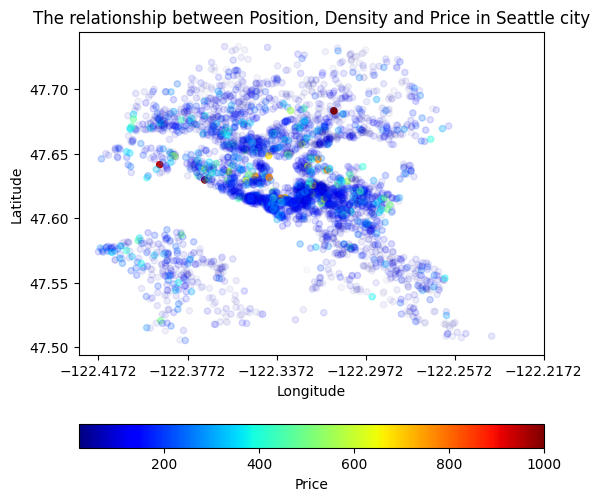

In [5]:
plot_hotel_coordinate(seattle_data)

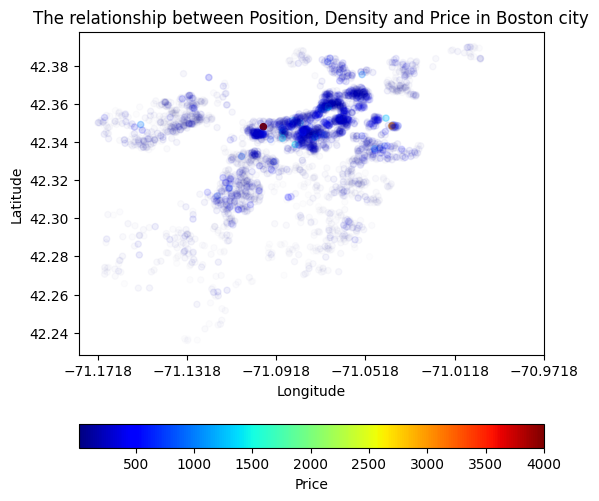

In [6]:
plot_hotel_coordinate(boston_data)

### Observations: 
- The higher of density, the higher hotel price
- The distance from the center is so far, the price is lower

### Comparations: 
- Boston has outlier price, the price distribution is around 1000.
- Boston has 1 center and Seattle has 2 centers

## Question 2: How does the month and room occupancy affect hotel prices. Which month has the highest capacity usage and is it a holiday?

In [7]:
def affect_occupancy_rate_to_price(airbnb_data):
    data = airbnb_data.calendar_df.groupby(
        airbnb_data.calendar_df["date"].dt.month, as_index=False
    ).agg({"price": "mean", "available": "mean"})

    data["available"].plot(kind="bar", ylabel="Occupancy rate", xlabel="Month")
    data["price"].plot(color="r", secondary_y=True, ylabel="Price")

    months = [
        "Jan",
        "Feb",
        "Mar",
        "Apr",
        "May",
        "Jun",
        "Jul",
        "Aug",
        "Sep",
        "Oct",
        "Nov",
        "Dec",
    ]
    plt.xticks(np.arange(12), months)

    plt.title(
        "The relationship between Occupancy rate and Price in {} city".format(
            airbnb_data.city_name
        )
    )
    plt.show()


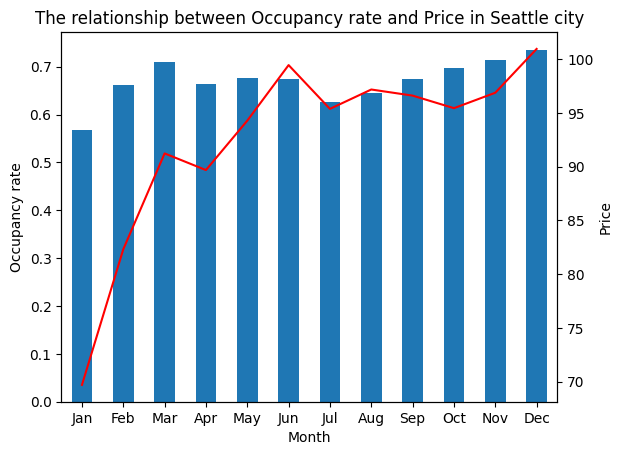

In [8]:
affect_occupancy_rate_to_price(seattle_data)

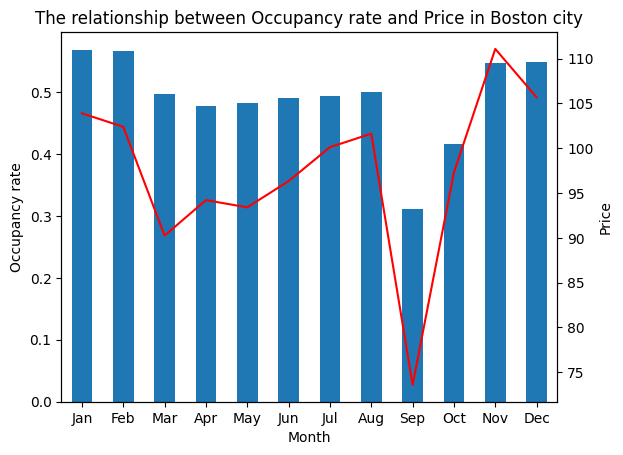

In [9]:
affect_occupancy_rate_to_price(boston_data)

### Observations: 
- The higher occupancy rate, the higher rent price 
- The highest capacity usage in Seattle is December, and in Boston is January, both are in Christmas and New Year holiday

### Comparations: 
Generally, the occupancy rate in Seattle is higher than Boston, and the price is cheaper than. 

## Question 3: How does the host information affect hotel prices? The higher price whether the host is reputable?

### Interested fields: 
- host_since
- host_response_time
- host_response_rate
- host_acceptance_rate
- host_is_superhost
- host_has_profile_pic
- host_identity_verified

### Method: 
Build a linear regression model, convert all interested fields to numeric values. The high weight of a value presents the more affect to hotel price.

In [10]:
def process_host_df(airbnb_data):
    listings_df = airbnb_data.listings_df

    interested_fields = [
        "host_since",
        "host_response_time",
        "host_response_rate",
        "host_acceptance_rate",
        "host_is_superhost",
        "host_has_profile_pic",
        "host_identity_verified",
        "price",
    ]
    df = listings_df[interested_fields]

    df["joined_year"] = datetime.datetime.now().year - df["host_since"].dt.year
    df = df.drop("host_since", axis=1)

    host_response_time_mapper = {
        "within an hour": 4,
        "within a few hours": 3,
        "within a day": 2,
        "a few days or more": 1,
        np.nan: 0,
    }
    df["host_response_time"] = df["host_response_time"].apply(
        lambda x: host_response_time_mapper[x]
    )

    df = df.fillna(0)

    return df


In [11]:
boston_host_df = process_host_df(boston_data)
seattle_host_df = process_host_df(seattle_data)

C:\Users\baole\AppData\Local\Temp\ipykernel_20028\3938553136.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["joined_year"] = datetime.datetime.now().year - df["host_since"].dt.year
C:\Users\baole\AppData\Local\Temp\ipykernel_20028\3938553136.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["joined_year"] = datetime.datetime.now().year - df["host_since"].dt.year


In [12]:
def linear_regression_host_predict(host_df):
    x = host_df.drop("price", axis=1)
    y = host_df["price"]

    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        x, y, test_size=0.25, random_state=42
    )

    model = linear_model.LinearRegression()
    model.fit(x_train, y_train)

    accuracy = model.score(x_train, y_train)
    y_test_preds = model.predict(x_test)

    test_score = metrics.r2_score(y_test, y_test_preds)
    print("The accuracy of model is {:.2f}".format(accuracy))
    print("The test accuracy of model is {:.2f}".format(test_score))

    print("Weight of variable:", model.coef_)


In [13]:
linear_regression_host_predict(seattle_host_df)

The accuracy of model is 0.04
The test accuracy of model is -0.01
Weight of variable: [-12.61430343   0.3872419   -0.31778395   6.72244016  44.29460275
   2.73557766   3.55121204]


In [14]:
linear_regression_host_predict(boston_host_df)

The accuracy of model is 0.02
The test accuracy of model is 0.01
Weight of variable: [ 4.62419876  0.2013914  -0.76423205  4.6786042  20.20909203 -3.82945157
  4.83758678]


### Observations:
- The accuracy of training data and testing data is too low
- Linear regression model cannot present the hotel price by host information
- The host information does not affect to hotel prices